In [1]:

import xarray as xr
import pandas as pd


ds_sat = xr.open_dataset('LGMR_data/ds_sat_flipped.nc')
ds_sat.info()

df_co2 = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\co2.csv")

# rename the second column to 'pre'
df_co2.columns = ['age', 'pre']

xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

# Cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def cal_raw_ccm_map_reversed(ds_sat, df_pre, E, tau, Tp,v_rage='auto',show_plot=True):
    """
    Compute and plot a global map of CCM skill using pyEDM's CCM.
    
    Parameters:
        E (int): Embedding dimension for CCM.
        tau (int): Time delay.
        Tp (int): Prediction horizon.
    
        ds_sat: xarray Dataset containing "sat", "lat", "lon", and "age".
        df_pre: pandas DataFrame with column "pre".
    """
    
    # Make sure the time series lengths match
    assert len(df_pre) == ds_sat.sizes["age"], "Timeseries length mismatch"

    # ------------------------------------------------
    # Prepare the grid and output array
    # ------------------------------------------------
    nlat = ds_sat.sizes["lat"]
    nlon = ds_sat.sizes["lon"]
    ages = ds_sat["age"].values
    rho_map = np.full((nlat, nlon), np.nan)
    
    # CCM parameter: library sizes (this could also be made an input if desired)
    libSizes = "10 20 30 40 50 60 70 80"
    
    # ------------------------------------------------
    # Loop over all lat/lon grid points and compute CCM skill
    # ------------------------------------------------
    for iLat in range(nlat):
        for iLon in range(nlon):
            # Extract the local "sat" time series
            sat_ts = ds_sat["sat"].isel(lat=iLat, lon=iLon).values

            # Build temporary DataFrame for CCM (predicting "X" using "Y")
            temp_df = pd.DataFrame({
                "Time": ages*-1,
                "X": df_pre["pre"],  # target (what we want to predict)
                "Y": sat_ts,         # predictor
            })

            # Run CCM (Y -> X)
            ccm_out = CCM(
                dataFrame   = temp_df,
                E           = E,
                tau         = tau,
                columns     = "Y",
                target      = "X",
                libSizes    = libSizes,
                sample      = 10,
                random      = True,
                replacement = False,
                Tp          = Tp
            )

            # Extract the mean CCM skill at the largest library size
            largest_L = ccm_out["LibSize"].max()
            mask_last = ccm_out["LibSize"] == largest_L
            rho_at_largest = ccm_out.loc[mask_last, "X:Y"]#.mean()
            rho_map[iLat, iLon] = rho_at_largest

    # ------------------------------------------------
    # Plot the global map using Cartopy (Robinson projection)
    # ------------------------------------------------
    lats = ds_sat["lat"].values
    lons = ds_sat["lon"].values
    # lats = np.array(ds_sat["lat"].values, dtype=np.float64)
    # lons = np.array(ds_sat["lon"].values, dtype=np.float64)

    if show_plot:
        fig = plt.figure(figsize=(11, 6))
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
        pcm = ax.pcolormesh(
            lons, lats, rho_map,
            transform=ccrs.PlateCarree(),  # data in lat/lon
            shading="auto"
        )
        ax.coastlines()
        
        if v_rage == 'auto':
            vmin, vmax = np.nanmin(rho_map), np.nanmax(rho_map)
        else:
            vmin, vmax = v_rage
        
        pcm.set_clim(vmin, vmax)
        cb = plt.colorbar(pcm, orientation="horizontal", pad=0.07, shrink=0.8)
        cb.set_label(r"CCM skill $\rho$ (\hat{sat}$|$M_{CO2})")

        
        plt.show()

    return rho_map

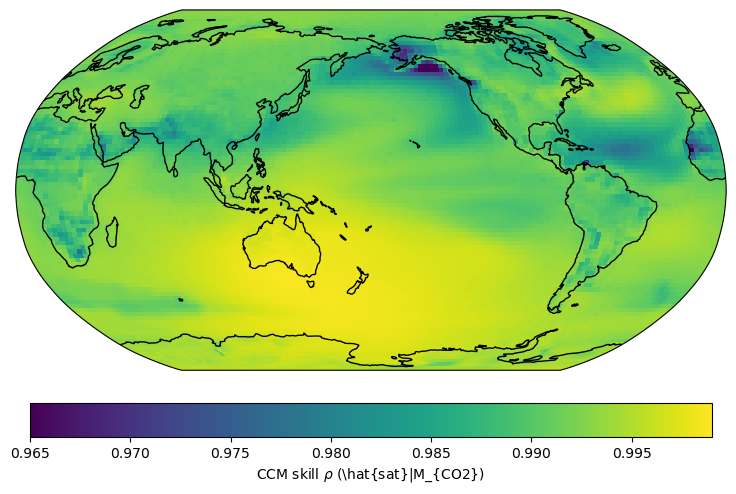

In [10]:


rwa_rho_map_Tp0=cal_raw_ccm_map_reversed(ds_sat=ds_sat, df_pre= df_co2, E=4, tau=3, Tp=0, v_rage=[0.965,0.999],show_plot=True)

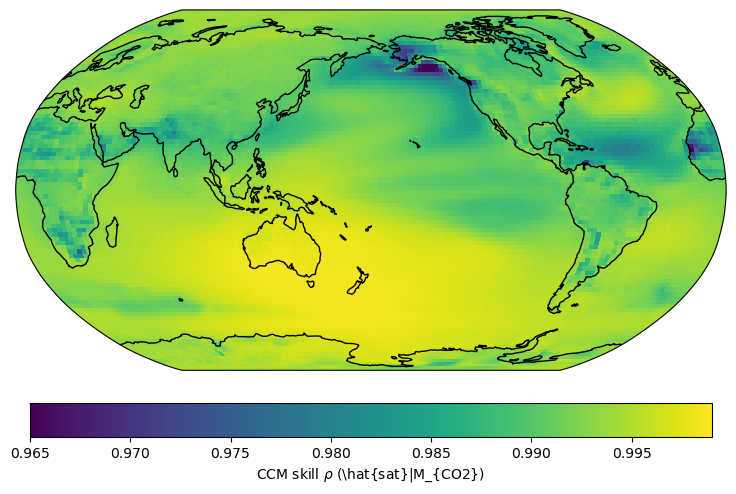

In [3]:
rwa_rho_map_Tp0=cal_raw_ccm_map_reversed(ds_sat=ds_sat, df_pre= df_co2, E=4, tau=3, Tp=1, v_rage=[0.965,0.999],show_plot=True)